# XGB + CV

In [28]:
import os
import re
import math
import string
import numpy as np
import pandas as pd
from collections import Counter 
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier  ## KNN
from sklearn.linear_model import LogisticRegressionCV  ## logistic regression
from sklearn.tree import DecisionTreeClassifier  ## decision tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

import xgboost
from xgboost import XGBClassifier

from preprocess import preprocess
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets
plt.rcParams['figure.figsize'] = [10, 8]

# 鐵達尼號資料集

In [29]:
df = pd.read_csv('train.csv')
df = preprocess(df)
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Cabin,Embarked,Has_Cabin,Age_Cat,Fare_log2,Fare_Cat,Name_Length,Name_With_Special_Char,Family_Size,Title
0,1,0,3,1,22.0,1,0,2,0,0,0,1,2.857981,0,23,0,1,1
1,2,1,1,0,38.0,1,0,5,3,2,1,2,6.155492,5,51,1,1,3
2,3,1,3,0,26.0,0,0,7,0,0,0,1,2.986411,0,22,0,0,2
3,4,1,1,0,35.0,1,0,1,3,0,1,2,5.730640,4,44,1,1,3
4,5,0,3,1,35.0,0,0,1,0,0,0,2,3.008989,0,24,0,0,1


In [30]:
X = df[['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Cabin', 'Embarked', 'Has_Cabin', 'Age_Cat', 'Fare_log2',
       'Fare_Cat', 'Name_Length', 'Name_With_Special_Char', 'Family_Size',
       'Title']].values
Y = df['Survived'].values

In [31]:
from sklearn.model_selection  import train_test_split

X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size =0.3, random_state=1212)  ## 一般如果測試資料集超過1000筆就可以了，所以比率不會設這麼高
print(X_train.shape)  ## (445, 17)
print(X_valid.shape)  ## (446, 17) 
print(Y_train.shape)  ## (445,)
print(Y_valid.shape)  ## (446,)

(623, 17)
(268, 17)
(623,)
(268,)


In [32]:
def get_accuracy(clf):
    #=============your works starts===============#
    clf = clf()
    clf =  clf.fit(X_train, Y_train)
    y_pred = clf.predict(X_valid)
    accuracy = (str(sum(Y_valid == y_pred)/Y_valid.shape[0]))
    #==============your works ends================#
    return accuracy

print('SVM: ', get_accuracy(SVC))
print('DecisionTree: ', get_accuracy(DecisionTreeClassifier))
print('RandomForest: ', get_accuracy(RandomForestClassifier))
print('AdaBoost: ', get_accuracy(AdaBoostClassifier))  ## Boosting的演算法
print('XGB: ', get_accuracy(XGBClassifier))

# SVM:  0.609865470852
# DecisionTree:  0.764573991031
# RandomForest:  0.795964125561
# AdaBoost:  0.784753363229
# XGB:  0.80269058296

SVM:  0.6455223880597015
DecisionTree:  0.7761194029850746
RandomForest:  0.832089552238806
AdaBoost:  0.7910447761194029


C:\Users\User\Jeremy\IIIMaterial\venv\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\User\Jeremy\IIIMaterial\venv\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


XGB:  0.8432835820895522


In [49]:
# Set our parameters for xgboost
params = {}
# 請填入以下參數: 
# 目標函數: 二元分類
# 評價函數: logloss
# 學習速度: 0.04
# 最大深度: 5
#=============your works starts===============#
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.04
params['max_depth'] = 3
#==============your works ends================#

d_train = xgboost.DMatrix(X_train, label=Y_train)
d_valid = xgboost.DMatrix(X_valid, label=Y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgboost.train(params, d_train, 100, watchlist, early_stopping_rounds=100, verbose_eval=0)
y_pred = bst.predict(xgboost.DMatrix(X_valid))
print("Accuracy: ", str(sum(Y_valid == (y_pred > 0.5))/Y_valid.shape[0]))


Accuracy:  0.835820895522388


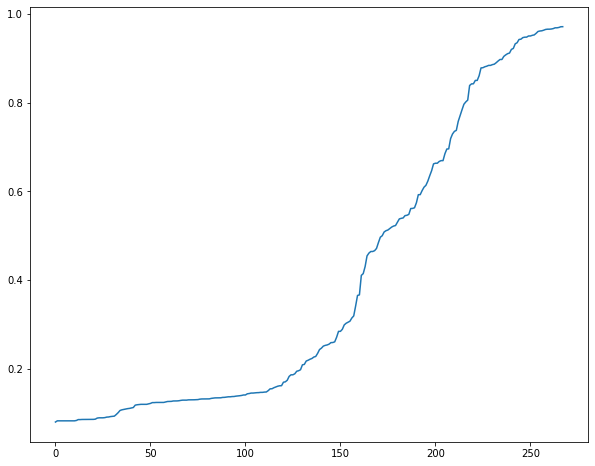

In [44]:
plt.plot(sorted(y_pred))
plt.show()

C:\Users\User\Jeremy\IIIMaterial\venv\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in long_scalars
  from ipykernel import kernelapp as app


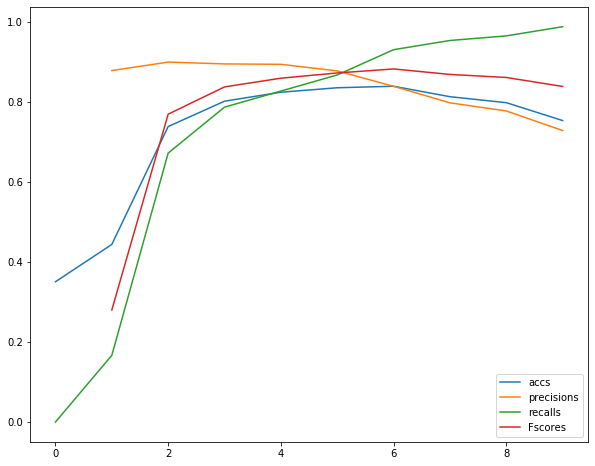

In [60]:
accs = []
precisions = []
recalls = []
Fscores = []
thresholds = np.arange(0, 1, 0.1)
for thres in thresholds:
    y_pred_inner = (y_pred>thres)
    y_pred_inner = ~y_pred_inner
    Y_valid_inner = ~Y_valid.astype(np.bool)
    acc = np.sum(y_pred_inner == Y_valid_inner) / len(Y_valid_inner)
    TP = np.sum((y_pred_inner == True) * (Y_valid_inner == True))
    TN = np.sum((y_pred_inner == False) * (Y_valid_inner == False))
    FP = np.sum((y_pred_inner == True) * (Y_valid_inner == False))
    FN = np.sum((y_pred_inner == False) * (Y_valid_inner == True))
    precision = TP / (TP+FP)
    recall = TP / (TP+FN)
    Fscore = 2*precision*recall / (precision + recall)
    accs.append(acc)
    precisions.append(precision)
    recalls.append(recall)
    Fscores.append(Fscore)
    
plt.plot(accs, label='accs')
plt.plot(precisions, label='precisions')
plt.plot(recalls, label='recalls')
plt.plot(Fscores, label='Fscores')
plt.legend()
plt.show()



# 空氣品質

In [7]:
# dateparse = lambda x: pd.datetime.strptime(x, '%d/%m/%Y %H:%M:%S')
# dateparse_1 = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
# EPA_6 = pd.read_csv('air_pollution_data/EPA_OD_201806.csv', parse_dates=['PublishTime'], date_parser=dateparse)
# EPA_7 = pd.read_csv('air_pollution_data/EPA_OD_201807.csv', parse_dates=['PublishTime'], date_parser=dateparse)
# EPA_8 = pd.read_csv('air_pollution_data/EPA_OD_201808.csv', parse_dates=['PublishTime'], date_parser=dateparse)
# EPA_9 = pd.read_csv('air_pollution_data/EPA_OD_201809.csv', parse_dates=['PublishTime'], date_parser=dateparse)
# EPA_10 = pd.read_csv('air_pollution_data/EPA_OD_201810.csv', parse_dates=['PublishTime'], date_parser=dateparse)
# EPA_11 = pd.read_csv('air_pollution_data/EPA_OD_201811.csv', parse_dates=['PublishTime'], date_parser=dateparse)
# EPA_12 = pd.read_csv('air_pollution_data/EPA_OD_201812.csv', parse_dates=['PublishTime'], date_parser=dateparse_1)
# frames = [EPA_6, EPA_7, EPA_8, EPA_9, EPA_10, EPA_11, EPA_12]
# df_AQI = pd.concat(frames)
# df_AQI.to_pickle('air_pollution_data.pkl')
# df_AQI.head()

In [8]:
# df_AQI = pd.read_pickle('air_pollution_data.pkl')
# df_AQI.sort_values(by='PublishTime', inplace=True)
# df_AQI = df_AQI.loc[df_AQI['SiteName'] == '麥寮', ['SiteName', 'AQI', 'PM2.5', 'SO2', 'PublishTime']]
# df_AQI.to_pickle('df_AQI_gl.pkl')

In [9]:
df_AQI = pd.read_pickle('df_AQI_gl.pkl')

In [10]:
window = 7
shift = 1
segments = int((df_AQI.shape[0] - window) // shift) + 1

train = np.zeros((segments-1, 2 * window))
target = np.zeros((segments-1,))
for segment in range(segments -1):
    seg = df_AQI.iloc[segment:segment+window][['SO2', 'PM2.5']]
    target[segment] = df_AQI.iloc[segment+window][['AQI']]
    train[segment] = np.append(seg['SO2'].values, seg['PM2.5'].values)

In [11]:
train = np.where(np.isnan(train), -1, train)
target = np.where(np.isnan(target), int(np.nanmean(target)), target)

In [12]:
train.shape, target.shape

((4721, 14), (4721,))

In [13]:
X_train, X_valid, Y_train, Y_valid = train_test_split(train, target, test_size=0.2, random_state=2019)
X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape

((3776, 14), (3776,), (945, 14), (945,))

In [14]:
# Set our parameters for xgboost
params = {}

# 請填入以下參數: 
# 目標函數: 線性回歸
# 評價函數: rmse
# 學習速度: 0.01
# 最大深度: 5
# bst = xgboost.train(params, d_train, 3000, watchlist, early_stopping_rounds=50, verbose_eval=10)
#=============your works starts===============#
params['objective'] = 'reg:linear'
params['eval_metric'] = 'rmse'
params['eta'] = 0.03
params['max_depth'] = 3
d_train = xgboost.DMatrix(X_train, label=Y_train)
d_valid = xgboost.DMatrix(X_valid, label=Y_valid)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]
bst = xgboost.train(params, d_train, 3000, watchlist, early_stopping_rounds=10, verbose_eval=10)
Y_pred = bst.predict(xgboost.DMatrix(X_valid))
#==============your works ends================#


[20:22:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:74.7182	valid-rmse:75.0921
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 10 rounds.
[10]	train-rmse:56.2433	valid-rmse:57.2731
[20]	train-rmse:42.8466	valid-rmse:44.581
[30]	train-rmse:33.2595	valid-rmse:35.6529
[40]	train-rmse:26.5246	valid-rmse:29.5798
[50]	train-rmse:21.8925	valid-rmse:25.5427
[60]	train-rmse:18.8046	valid-rmse:22.983
[70]	train-rmse:16.7946	valid-rmse:21.4035
[80]	train-rmse:15.4931	valid-rmse:20.4358
[90]	train-rmse:14.6551	valid-rmse:19.8031
[100]	train-rmse:14.1008	valid-rmse:19.4283
[110]	train-rmse:13.7185	valid-rmse:19.2046
[120]	train-rmse:13.4202	valid-rmse:19.0727
[130]	train-rmse:13.1949	valid-rmse:19.0049
[140]	train-rmse:13.0321	valid-rmse:18.9568
[150]	train-rmse:12.8907	valid-rmse:18.9242


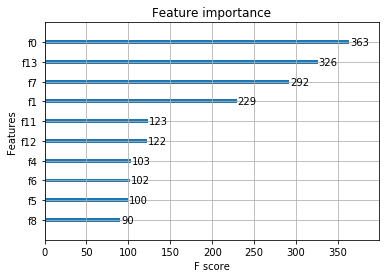

In [15]:
# 請使用 xgboost.plot_importance，並設定max_num_features=10
#!=============your works starts===============!#
xgboost.plot_importance(bst, max_num_features=10)
#!==============your works ends================!#

plt.show()

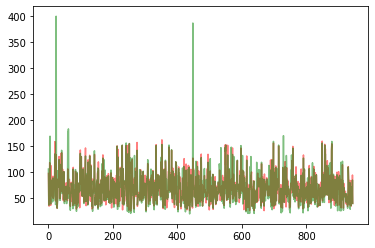

In [16]:
plt.plot(Y_pred, label='Y_pred', alpha=0.5, c='r')
plt.plot(Y_valid, label='Y_valid', alpha=0.5, c='g')
plt.show()

In [17]:
df_result = pd.DataFrame()

# 1. 使用X_valid去評價此模型
# 2. 使用 ['predict', 'truth', 'error'] 三個欄位的DataFrame去使決畫呈現預測結果
#    (1). 請注意與測結果(Y_pred)與真實值(Y_valid)都必須取exp方能反映實際情況
#    (2). error 請使用計算np.abs(predict-truth)/truth計算誤差百分比
# 3. 使用truth欄位排序dataframe rows
#=============your works starts===============#
Y_pred = bst.predict(xgboost.DMatrix(X_valid))
df_result['predict'] = Y_pred
df_result['truth'] = Y_valid
df_result['error'] = np.abs(Y_pred - Y_valid) / Y_valid
df_result_sort = df_result.sort_values('truth')
#==============your works ends================#

df_result_sort.head()

,predict,truth,error
438,26.421331,20.0,0.321067
619,32.649693,21.0,0.554747
255,25.611446,21.0,0.219593
624,26.643148,21.0,0.268721
638,26.557676,21.0,0.264651


c:\users\thinktron\projects\iiimaterial\venv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='hist')` instead of `Series.plot('hist',)`.
  This is separate from the ipykernel package so we can avoid doing imports until


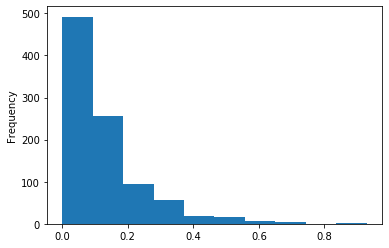

In [18]:
# 請使用df_result_sort濾掉error大於1的部分畫出error的分布圖
#!=============your works starts===============!#
df_result_sort.loc[df_result_sort['error'] < 1, 'error'].plot('hist')
#!==============your works ends================!#

plt.show()

No handles with labels found to put in legend.


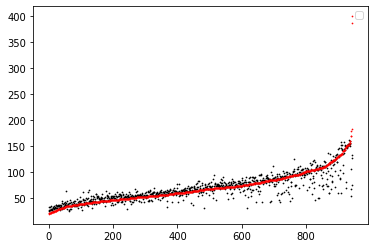

In [19]:
# 請使用plt.scatter，以0~len(df_result)作為x，預測值(黑色)與實際值(紅色)作為y。
#!=============your works starts===============!#
plt.scatter(range(len(df_result)), df_result_sort['predict'].values, color='black', s=0.5)
plt.scatter(range(len(df_result)), df_result_sort['truth'].values, color='red', s=0.5)
#!==============your works ends================!#

plt.legend()
plt.show()

# 水稻田

In [83]:
import os
import tarfile
import shutil
import pandas as pd
import numpy as np
import pylab as plt
import cv2
img_dir = os.path.join('farm_data', 'lands_pieces_tif_practice')


In [19]:
class Normalizer():
    def fit(self, X, min_val=None, max_val=None):
        self.min = np.nanmin(X) if min_val == None else min_val
        self.max = np.nanmax(X) if max_val == None else max_val
        
    def transform(self, X):
        return (X - self.min) / (self.max - self.min)

    def fit_transform(self, X, min_val=None, max_val=None):
        self.fit(X, min_val, max_val)
        return self.transform(X)
        
    def reverse_transform(self, Y):
        return (Y * (self.max - self.min)) + self.min


In [2]:
if not os.path.isdir(img_dir):
    tar = tarfile.open(os.path.join('farm_data',  'lands_pieces_tif_practice.tar.gz'))
    names = tar.getnames()
    for name in names:
        tar.extract(name,path=os.path.join('farm_data'))
    tar.close()

In [77]:
# fps = [os.path.join(img_dir, fn) for fn in os.listdir(img_dir)]
# i=0
# for fp in fps[:10]:
#     X = get_nparray(fp)
#     X = X[:, :, [i+3, i+2, i+1]]
#     X[X==0] = 1
#     X = np.log(X)
#     plt.imshow(X)
#     plt.imshow(Normalizer().fit_transform(X, min_val=0, max_val=9.913))
#     plt.show()


In [ ]:
def get_nparray(fp):
    # use np.load to load npy data
    with open(fp, 'rb') as f:
        #=============your works starts===============#
        X = np.load(f)
        #==============your works ends================#
    return X

def pad_img_to_300(X, pad_to_n_cols, pad_to_n_rows):
    rows, cols = X.shape[:2]
    padded_cols = pad_to_n_cols - cols if cols < pad_to_n_cols else 0
    padded_rows = pad_to_n_rows - rows if rows < pad_to_n_rows else 0
    # use np.pad with param('constant', constant_values=0) to pad_to_n_cols, pad_to_n_rows
    #=============your works starts===============#
    X = np.pad(X, ((0, padded_rows), (0, padded_cols), (0,0)), 'constant', constant_values=0)[:pad_to_n_rows, :pad_to_n_cols]
    #==============your works ends================#
    return X

In [84]:
# 1. get all fps for  os.listdir(img_dir)
# 2. get all data from get_nparray
# 3. pad_img_to_300
# 4. use cv2 to resize  to (50, 50 ,-1) and flatten it
# 5. flatten X
#=============your works starts===============#
fps = [os.path.join(img_dir, fn) for fn in os.listdir(img_dir)]
X = [get_nparray(fp) for fp in fps]
X = [pad_img_to_300(x, 300, 300) for x in X]
X = np.array([cv2.resize(x, (50,50)).flatten() for x in X])
#==============your works ends================#

X.shape

(2685, 42500)

In [79]:
# 1. read csv  from os.path.join('farm_data', 'df_lands.csv')
# 2. get all idxs from filename
# 3. select CULTURE as Y
#=============your works starts===============#
df_lands = pd.read_csv(os.path.join('farm_data', 'df_lands.csv'))
sel_idxs = [int(fn.replace('.npy', '')) for fn in os.listdir(img_dir)]
Y = df_lands.loc[sel_idxs, 'CULTURE'].values
#==============your works ends================#

Y.shape

(2685,)

In [86]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.3, random_state=2019)
X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape

((1879, 42500), (1879,), (806, 42500), (806,))

# 房價資料集

In [20]:
# import urllib.request
# if 'df_realestate_processed.csv' not in os.listdir():
#     url = 'https://s3.amazonaws.com/datasets-jeremy/df_realestate_processed.csv'  
#     urllib.request.urlretrieve(url, 'df_realestate_processed.csv')
    
# # processed
# path = "df_realestate_processed.csv"
# df_realestate_processed = pd.read_csv(path)
# X = df_realestate_processed.drop(["price_per_meter", "total_price"], axis=1)
# Y = df_realestate_processed['total_price']


In [21]:
# X_train = X.iloc[:-1000]
# Y_train = Y.iloc[:-1000]
# Y_train = np.log(Y_train) 

# X_valid = X.iloc[-1000:]
# Y_valid = Y.iloc[-1000:]
# Y_valid = np.log(Y_valid) 

In [22]:
# # Set our parameters for xgboost
# params = {}

# # 請填入以下參數: 
# # 目標函數: 線性回歸
# # 評價函數: rmse
# # 學習速度: 0.01
# # 最大深度: 5
# # bst = xgboost.train(params, d_train, 3000, watchlist, early_stopping_rounds=50, verbose_eval=10)
# #=============your works starts===============#
# params['objective'] = 'reg:linear'
# params['eval_metric'] = 'rmse'
# params['eta'] = 0.03
# params['max_depth'] = 3
# d_train = xgboost.DMatrix(X_train, label=Y_train)
# d_valid = xgboost.DMatrix(X_valid, label=Y_valid)
# watchlist = [(d_train, 'train'), (d_valid, 'valid')]
# bst = xgboost.train(params, d_train, 3000, watchlist, early_stopping_rounds=10, verbose_eval=10)
# Y_pred = bst.predict(xgboost.DMatrix(X_valid))
# #==============your works ends================#


In [23]:
#　模型save與load的方式自己看
# bst.save_model("bst_subtotal_log_with_cross.pickle.dat")
# bst = xgboost.Booster({'nthread':1}) #init model
# bst.load_model("bst_subtotal_log_with_cross.pickle.dat") # load data


In [24]:
# # 請使用 xgboost.plot_importance，並設定max_num_features=10
# #!=============your works starts===============!#
# xgboost.plot_importance(bst, max_num_features=10)
# #!==============your works ends================!#

# plt.show()

In [25]:
# df_result = pd.DataFrame()

# # 1. 使用X_valid去評價此模型
# # 2. 使用 ['predict', 'truth', 'error'] 三個欄位的DataFrame去使決畫呈現預測結果
# #    (1). 請注意與測結果(Y_pred)與真實值(Y_valid)都必須取exp方能反映實際情況
# #    (2). error 請使用計算np.abs(predict-truth)/truth計算誤差百分比
# #=============your works starts===============#
# Y_pred = bst.predict(xgboost.DMatrix(X_valid))
# df_result['predict'] = np.exp(Y_pred)
# df_result['truth'] = np.exp((list(Y_valid)))
# df_result['error'] = df_result.apply(lambda x:np.abs(x['predict'] - x['truth']) / x['truth'], axis=1)
# df_result_sort = df_result.sort_values('truth')
# #==============your works ends================#

# df_result.head()

In [26]:
# # 請使用df_result_sort濾掉error大於1的部分畫出error的分布圖
# #!=============your works starts===============!#
# df_result_sort.loc[df_result_sort['error'] < 1, 'error'].plot('hist')
# #!==============your works ends================!#

# plt.show()

In [27]:
# # 請使用plt.scatter，以0~len(df_result)作為x，預測值(黑色)與實際值(紅色)作為y。
# #!=============your works starts===============!#
# plt.scatter(range(len(df_result)), df_result_sort['predict'].values, color='black', s=0.5)
# plt.scatter(range(len(df_result)), df_result_sort['truth'].values, color='red', s=0.5)
# #!==============your works ends================!#

# plt.show()